In [12]:
import pandas as pd
import matplotlib.pyplot as plt
groundtruth_df = pd.read_csv('/Users/pedro.josealvarez/Downloads/ISIC_2024_Training_GroundTruth.csv')
metadata_df = pd.read_csv('/Users/pedro.josealvarez/Downloads/ISIC_2024_Training_Input/metadata.csv')
metadata_df = metadata_df.dropna(subset=['age_approx', 'sex', 'anatom_site_general'])
metadata_df['is_60_plus'] = (metadata_df.age_approx >= 60).astype(int)
metadata_df['is_head_neck'] = (metadata_df.anatom_site_general == 'head/neck').astype(int)


df = metadata_df.merge(groundtruth_df, on='isic_id')


KeyboardInterrupt: 

In [ ]:
import tensorflow as tf
import numpy as np
import os

IMG_SIZE = (224, 224) 
IMAGE_DIR = '/Users/pedro.josealvarez/Downloads/ISIC_2024_Training_Input'

def load_image(isic_id):
    path = os.path.join(IMAGE_DIR, isic_id + '.jpg')
    image = tf.io.read_file(path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, IMG_SIZE)
    image = tf.cast(image, tf.float32) / 255.0  # normalize
    return image


In [ ]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split

df.head()

X_metadata = df[['is_60_plus', 'is_head_neck']].values.astype(np.float32)
##X_image = np.stack([load_image(isic_id).numpy() for isic_id in df['isic_id']])
y = df['malignant'].values

# Split all three together (image, metadata, label)
X_meta_train, X_meta_val, y_train, y_val = train_test_split( X_metadata, y, test_size=0.2, random_state=42)

## Naive model: Metadata one-hots only model
     Only use one-hot variables for head/neck & 60+plus age

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models

# Define model
meta_model = models.Sequential([
    layers.Input(shape=(2,)),                 # 2 binary features
    layers.Dense(16, activation='relu'),
    layers.Dense(8, activation='relu'),
    layers.Dense(1, activation='sigmoid')     # Binary output
])

# Compile
meta_model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Train on metadata only
meta_model.fit(
    X_meta_train, y_train,
    validation_data=(X_meta_val, y_val),
    epochs=10,
    batch_size=64
)


# Evaluate accuracy on validation set
loss, acc = meta_model.evaluate(X_meta_val, y_val)
print(f"Validation Accuracy: {acc:.3f}")

Epoch 1/10
4774/4774 ━━━━━━━━━━━━━━━━━━━━ 3s 530us/step - accuracy: 0.9988 - loss: 0.0745 - val_accuracy: 0.9990 - val_loss: 0.0077
Epoch 2/10
4774/4774 ━━━━━━━━━━━━━━━━━━━━ 3s 536us/step - accuracy: 0.9992 - loss: 0.0066 - val_accuracy: 0.9990 - val_loss: 0.0077
Epoch 3/10
4774/4774 ━━━━━━━━━━━━━━━━━━━━ 2s 510us/step - accuracy: 0.9990 - loss: 0.0078 - val_accuracy: 0.9990 - val_loss: 0.0079
Epoch 4/10
4774/4774 ━━━━━━━━━━━━━━━━━━━━ 3s 603us/step - accuracy: 0.9990 - loss: 0.0074 - val_accuracy: 0.9990 - val_loss: 0.0079
Epoch 5/10
4774/4774 ━━━━━━━━━━━━━━━━━━━━ 2s 478us/step - accuracy: 0.9990 - loss: 0.0077 - val_accuracy: 0.9990 - val_loss: 0.0080
Epoch 6/10
4774/4774 ━━━━━━━━━━━━━━━━━━━━ 2s 453us/step - accuracy: 0.9989 - loss: 0.0085 - val_accuracy: 0.9990 - val_loss: 0.0078
Epoch 7/10
4774/4774 ━━━━━━━━━━━━━━━━━━━━ 2s 457us/step - accuracy: 0.9989 - loss: 0.0083 - val_accuracy: 0.9990 - val_loss: 0.0078
Epoch 8/10
4774/4774 ━━━━━━━━━━━━━━━━━━━━ 2s 437us/step - accuracy: 0.9990 -

2387/2387 ━━━━━━━━━━━━━━━━━━━━ 0s 193us/step


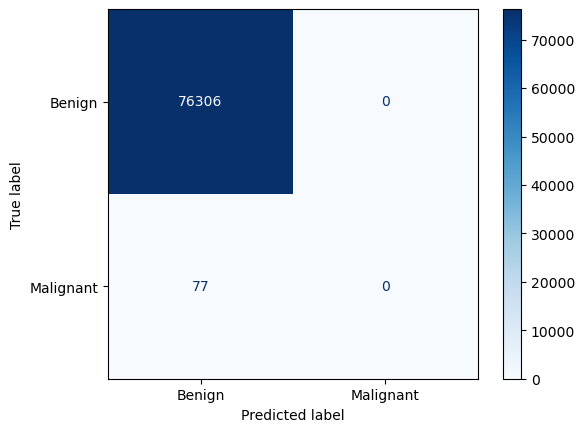

In [ ]:
# Predict probabilities on validation set
y_pred_probs = meta_model.predict(X_meta_val)

# Convert probabilities to class predictions (0 or 1)
y_pred = (y_pred_probs >= 0.5).astype(int)

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Compute confusion matrix
cm = confusion_matrix(y_val, y_pred)

# Optional: plot it
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Benign", "Malignant"])
disp.plot(cmap='Blues')



#### Evaluation of simple model 1

* the model is predicting 100% benign. it's simply not predicting malignant as so few of the images in this index are malignatn
* it seems like the model learned to simply always guess the majority class, which given the sharp class imbalance, optimizes for accuracy
* _what to change/do differently_: 
    * apply class weights in the loss function to overweight the corrective effects incorrect predictions have.
    * in the model below, we specifically apply a weight such that if malignant cases are x% of the data, they are weighted approximately 1/x times more to contribute equivalently to the corrective model

In [ ]:
# Manually compute class weights
from sklearn.utils.class_weight import compute_class_weight
import numpy as np


classes = np.unique(y_train)
class_weights = compute_class_weight(class_weight='balanced', classes=classes, y=y_train)
class_weight_dict = dict(zip(classes, class_weights))

print(class_weight_dict)

meta_model.fit(
    X_meta_train, y_train,
    validation_data=(X_meta_val, y_val),
    epochs=10,
    batch_size=64,
    class_weight=class_weight_dict 

)

{0.0: 0.5004979900205421, 1.0: 502.5180921052632}
Epoch 1/10
4774/4774 ━━━━━━━━━━━━━━━━━━━━ 2s 461us/step - accuracy: 0.8747 - loss: 0.8259 - val_accuracy: 0.4570 - val_loss: 0.6875
Epoch 2/10
4774/4774 ━━━━━━━━━━━━━━━━━━━━ 2s 459us/step - accuracy: 0.4666 - loss: 0.6923 - val_accuracy: 0.9691 - val_loss: 0.5690
Epoch 3/10
4774/4774 ━━━━━━━━━━━━━━━━━━━━ 2s 457us/step - accuracy: 0.6364 - loss: 0.6407 - val_accuracy: 0.4570 - val_loss: 0.6251
Epoch 4/10
4774/4774 ━━━━━━━━━━━━━━━━━━━━ 2s 460us/step - accuracy: 0.8483 - loss: 0.6289 - val_accuracy: 0.4570 - val_loss: 0.5920
Epoch 5/10
4774/4774 ━━━━━━━━━━━━━━━━━━━━ 2s 458us/step - accuracy: 0.6282 - loss: 0.6738 - val_accuracy: 0.4570 - val_loss: 0.6578
Epoch 6/10
4774/4774 ━━━━━━━━━━━━━━━━━━━━ 2s 453us/step - accuracy: 0.4899 - loss: 0.6527 - val_accuracy: 0.4570 - val_loss: 0.6353
Epoch 7/10
4774/4774 ━━━━━━━━━━━━━━━━━━━━ 2s 467us/step - accuracy: 0.7721 - loss: 0.6294 - val_accuracy: 0.4570 - val_loss: 0.6573
Epoch 8/10
4774/4774 ━━━━━

2387/2387 ━━━━━━━━━━━━━━━━━━━━ 0s 200us/step


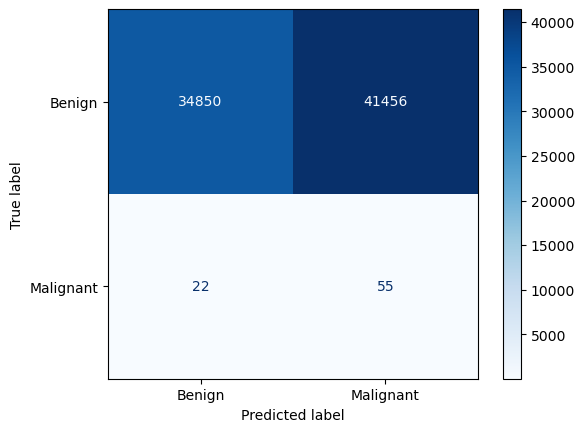

In [ ]:
# Predict probabilities on validation set
y_pred_probs = meta_model.predict(X_meta_val)

# Convert probabilities to class predictions (0 or 1)
y_pred = (y_pred_probs >= 0.5).astype(int)

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Compute confusion matrix
cm = confusion_matrix(y_val, y_pred)

# Optional: plot it
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Benign", "Malignant"])
disp.plot(cmap='Blues')

### final metadata model analysis:
* this model has an extremely high false positivity rateas  a huge portion of benign lesions (over 50%) are classified as malignant
* in spite of the false positivty issues, its recall is a solid 71% of the few malignant cases
* obviously, this is an incomplete model that discards a host of additional metadata features and all of the visual cues offered by images. to account for this, we will compare it to a simple CNN built off the images in our dataset next. 

## Images-only CNN:

In [13]:
import tensorflow as tf
import pandas as pd
import os

IMG_SIZE = (224, 224)
BATCH_SIZE = 32

df = df[['isic_id', 'malignant']][:10000]

def path_label_pair(row):
    img_path = os.path.join(
        '/Users/pedro.josealvarez/Downloads/ISIC_2024_Training_Input',
        row['isic_id'] + '.jpg'
    )
    return img_path, row['malignant']

image_paths, labels = zip(*df.apply(path_label_pair, axis=1))

# Convert to tf.data.Dataset
image_ds = tf.data.Dataset.from_tensor_slices((list(image_paths), list(labels)))

def preprocess(path, label):
    image = tf.io.read_file(path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, IMG_SIZE)
    image = tf.cast(image, tf.float32) / 255.0
    return image, tf.cast(label, tf.float32)

image_ds = image_ds.map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)
image_ds = image_ds.shuffle(buffer_size=1000)


In [14]:
# Split into 80/20
total_size = len(df)
val_size = int(0.2 * total_size)

train_ds = image_ds.skip(val_size).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
val_ds = image_ds.take(val_size).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)


In [15]:
from tensorflow.keras import layers, models

cnn_model = models.Sequential([
    layers.Input(shape=(224, 224, 3)),
    layers.Conv2D(32, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, activation='relu'),
    layers.Flatten(),
    layers.Dropout(0.3),
    layers.Dense(1, activation='sigmoid')
])

cnn_model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)


In [16]:
cnn_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10
)


Epoch 1/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 71s 279ms/step - accuracy: 0.9732 - loss: 0.1557 - val_accuracy: 0.9980 - val_loss: 0.0426
Epoch 2/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 69s 275ms/step - accuracy: 0.9982 - loss: 0.0351 - val_accuracy: 0.9985 - val_loss: 0.0273
Epoch 3/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 68s 270ms/step - accuracy: 0.9989 - loss: 0.0247 - val_accuracy: 0.9980 - val_loss: 0.0167
Epoch 4/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 67s 269ms/step - accuracy: 0.9992 - loss: 0.0144 - val_accuracy: 0.9985 - val_loss: 0.0124
Epoch 5/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 66s 264ms/step - accuracy: 0.9989 - loss: 0.0097 - val_accuracy: 0.9980 - val_loss: 0.0200
Epoch 6/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 66s 262ms/step - accuracy: 0.9965 - loss: 0.0400 - val_accuracy: 0.9980 - val_loss: 0.0662
Epoch 7/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 66s 262ms/step - accuracy: 0.9984 - loss: 0.0305 - val_accuracy: 0.9980 - val_loss: 0.0162
Epoch 8/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 66s 261ms/step - accuracy: 0.9992 - loss: 0

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np

val_ds = image_ds.take(val_size).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

# Predict probabilities
y_probs = cnn_model.predict(val_ds)

# Convert probabilities to binary class predictions
y_pred = (y_probs >= 0.5).astype(int).flatten()

# Extract ground truth labels from val_ds
y_true = np.concatenate([y.numpy() for _, y in val_ds])

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Display
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Benign", "Malignant"])
disp.plot(cmap="Blues")


ValueError: Exception encountered when calling Sequential.call().

[1mInput 0 of layer "dense_20" is incompatible with the layer: expected axis -1 of input shape to have value 238144, but received input with shape (32, 760384)[0m

Arguments received by Sequential.call():
  • inputs=tf.Tensor(shape=(32, 224, 224, 3), dtype=float32)
  • training=False
  • mask=None
  • kwargs=<class 'inspect._empty'>